In [10]:
import pandas as pd
import numpy as np
import calculate_cleavage_rate as clv
%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
reload(clv)
import sys
import Nucleaseq_data_processing as processing
reload(processing)

model_ID = ['Clv_Saturated_general_energies_v2','general_energies_no_kPR']
times = [0.0,12.0,60.0,180.0,600.0,1800.0,6000.0,18000.0,60000.0]
guide = 20

path_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
filename_data = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'

### Show result of fit

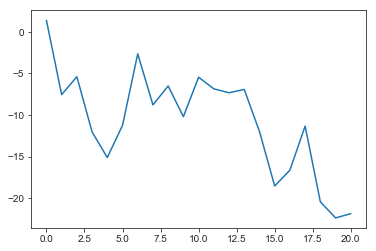

In [11]:
filename = 'fit_30_4_2019a_sim_1.txt'
path = '../fits_Stijn/30_4_2019a/'
data = pd.read_table(path+filename,index_col=False)
final_par = data.loc[len(data)-1,'Parameter 1':'Parameter 42']
final_par_np = final_par.values
chi = data.loc[:,'Potential']


#When not all 44 parameters are present
all_par = np.zeros(44)
all_par[0] = 1.4 #PAM
all_par[1:21] = final_par_np[0:20] #eC
all_par[21:41] = final_par_np[20:40] #eI
all_par[41] = -2.3 #rate from solution
all_par[42] = final_par_np[40] #internal rate
all_par[43] = final_par_np[41] #cleavage rate
final_par_np = all_par

plt.plot(range(0,21),-np.cumsum(np.append([-final_par_np[0]],final_par_np[1:21])))

### Errorbars, weighted average kclv

In [4]:
filename = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
xdata, ydata, yerr = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data)
_, ydatawa, yerrwa = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,True)
#_, ydatamedian, yerrmedian = processing.prepare_multiprocessing_nucleaseq(filename, path_to_data, True)

datacompclv = []
datacompon = []
pos = []
kclv = []
kon = []
errorclv = []
erroron = []

i = 1
while i < guide+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            pos.append(xdata[a][0])
            kclv.append(ydatawa[a][0][0])
            kon.append(ydatawa[a][1][0])
            errorclv.append(yerrwa[a][0][0])
            datacompclv.append(ydata[a][0])
            datacompon.append(ydata[a][1])
            erroron.append(yerrwa[a][1][0])
            
            i = i + 1
    
pos.append(21)
kclv.append(ydatawa[0][0][0])
kon.append(ydatawa[0][1][0])
errorclv.append(yerr[0][0][0])
erroron.append(yerr[0][1][0])
datacompclv.append(ydata[0][0])
datacompon.append(ydata[0][1])


pos = np.array(pos)
kclv = np.array(kclv)
kon = np.array(kon)
errorclv = np.array(errorclv)
erroron = np.array(erroron)

In [5]:
k_double = np.zeros([20,20])
on_double = np.zeros([20,20])

for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = (ydatawa[a][0][0])
        if len(ydata[a][1])==0:
            on_double[j-1,i-1] = np.nan
        else:
            on_double[j-1,i-1] = np.log10(ydatawa[a][1][0])
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
on_double_df = pd.DataFrame(on_double, index=range(1,21), columns=range(1,21))


## Single mismatches

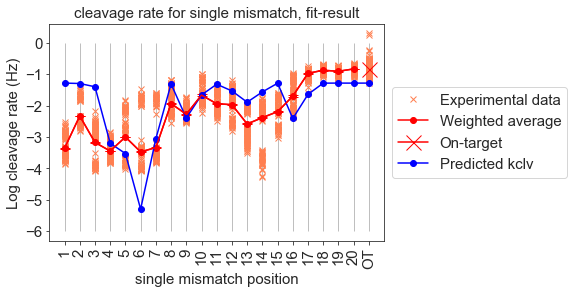

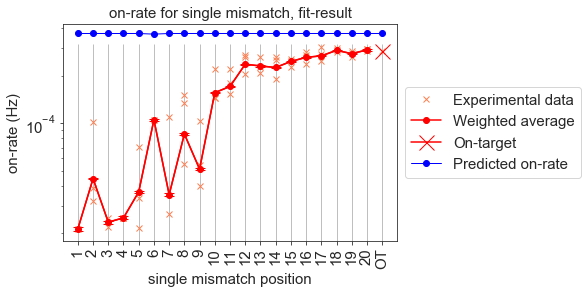

In [12]:
k = np.zeros(21)
on = np.zeros(21)
for i in range(1,guide+1):
    mismatch = [i]
    k[i-1],on[i-1] = clv.calc_clv_on(final_par_np,model_ID,mismatch,guide)
    
k[-1],on[-1] = clv.calc_clv_on(final_par_np,model_ID,[],guide)
    
plt.figure()
for i in range(21):
    plot1 = plt.plot((i+1)*np.ones(len(datacompclv[i])),datacompclv[i],marker='x',color='coral',linewidth=0,label='Experimental data')
plot2 = plt.plot(range(1,21),kclv[0:20],marker='o',color='r',label='Weighted average')
plt.errorbar(range(1,21),kclv[0:20],yerr=errorclv[0:20],color='r',capsize=5)
plot3 = plt.plot(21,kclv[20],marker='x',color='r',markersize=15,label='On-target')
plot4 = plt.plot(range(1,22),np.log10(k),color='b',marker='o',label='Predicted kclv')
plt.legend(handles=[plot1[0],plot2[0],plot3[0],plot4[0]],loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
plt.xlabel('single mismatch position', fontsize=15)
plt.ylabel('Log cleavage rate (Hz)', fontsize=15)
plt.title('cleavage rate for single mismatch, fit-result', fontsize=15)
plt.xticks(range(1,21)+[21],range(1,21)+['OT'],fontsize=15,rotation='vertical')
plt.yticks(fontsize=15)
plt.vlines(range(1,22),-6,0,color='grey',linewidth=0.5);
#plt.axis([0,22,10**(-5),10**(0)]);

plt.figure()
for i in range(21):
    plot1 = plt.plot((i+1)*np.ones(len(datacompon[i])),datacompon[i],marker='x',color='coral',linewidth=0,label='Experimental data')
plot2 = plt.plot(range(1,21),kon[0:20],marker='o',color='r',label='Weighted average')
plot3 = plt.plot(21,kon[20],marker='x',color='r',markersize=15,label='On-target')
plot4 = plt.semilogy(range(1,22),on,marker='o',linewidth=1,color='blue',label='Predicted on-rate')
plt.errorbar(range(1,21),kon[0:20],yerr=erroron[0:20],color='r',capsize=5)
plt.legend(handles=[plot1[0],plot2[0],plot3[0],plot4[0]],loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
plt.xlabel('single mismatch position', fontsize=15)
plt.ylabel('on-rate (Hz)', fontsize=15)
plt.title('on-rate for single mismatch, fit-result', fontsize=15)
plt.xticks(range(1,21)+[21],range(1,21)+['OT'],fontsize=15,rotation='vertical')
plt.yticks(fontsize=15)
plt.vlines(range(1,22),0,10**-3.5,color='grey',linewidth=0.5);
#plt.axis([0,22,10**-6,10**0])

## Double mismatches

Text(0.5,1,'on-rate double mismatches \ntop=model bottom=experiment')

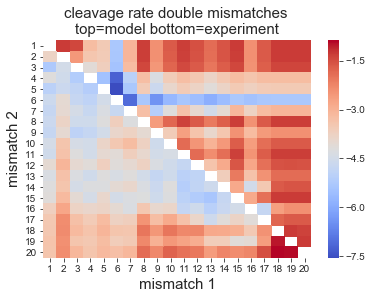

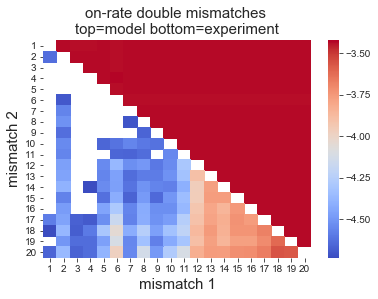

In [13]:
k_matrix = np.zeros([20,20])
on_matrix = np.zeros([20,20])

for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_matrix[i-1,j-1], on_matrix[i-1,j-1] = np.log10(clv.calc_clv_on(final_par_np,model_ID,mismatch_positions,guide))
        
        
k_df = pd.DataFrame(k_matrix, index=range(1, 21), columns=range(1, 21))
on_df = pd.DataFrame(on_matrix, index=range(1,21), columns=range(1,21))
combined_df_wa = k_df + k_double_df
combined_on = on_df + on_double_df

for i in range(1,21):
    combined_df_wa[i].loc[i]=np.nan
    combined_on[i].loc[i] = np.nan

plt.figure()
sns.heatmap(combined_df_wa, cmap='coolwarm', cbar=True)#, vmin=-8, vmax = -1)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)
plt.title('cleavage rate double mismatches \ntop=model bottom=experiment', fontsize=15)

plt.figure()
sns.heatmap(combined_on,cmap='coolwarm', cbar=True)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)
plt.title('on-rate double mismatches \ntop=model bottom=experiment', fontsize=15)

## Correlations

Text(0,0.5,'Measured on-rate (Hz)')

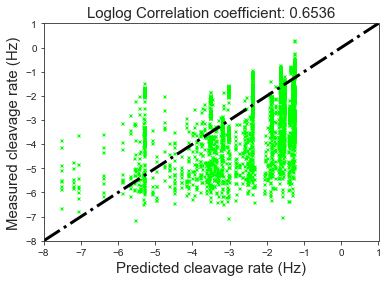

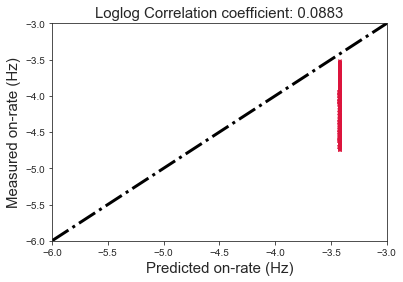

In [14]:
datacleave = []
fitcleave = []
dataon = []
fiton = []

for i in range(len(xdata)):
    cleavagetemp, ontemp = np.log10(clv.calc_clv_on(final_par_np,model_ID,xdata[i],guide))
    for j in range(len(ydata[i][0])):
        if (ydata[i][0][j])>(-10):
            datacleave.append(ydata[i][0][j])
            fitcleave.append(cleavagetemp)
    for j in range(len(ydata[i][1])):
        dataon.append(np.log10(ydata[i][1][j]))
        fiton.append(ontemp)
        
        
plt.figure()
plt.plot(fitcleave,datacleave,marker='x',markersize=3,color='lime',linewidth=0.0)
plt.plot([-8,1],[-8,1],'k-.',linewidth=3)
plt.axis([-8,1,-8,1])
plt.title('Loglog Correlation coefficient: ' + str(np.round(np.corrcoef([datacleave,fitcleave])[0][1],4)), fontsize=15)
plt.xlabel('Predicted cleavage rate (Hz)',fontsize=15)
plt.ylabel('Measured cleavage rate (Hz)',fontsize=15)

plt.figure()
plt.plot(fiton,dataon,marker='x',markersize=3,color='crimson',linewidth=0.0)
plt.plot([-7,0],[-7,0],'k-.',linewidth=3)
plt.axis([-6,-3,-6,-3])
plt.title('Loglog Correlation coefficient: ' + str(np.round(np.corrcoef([dataon,fiton])[0][1],4)), fontsize=15)
plt.xlabel('Predicted on-rate (Hz)',fontsize=15)
plt.ylabel('Measured on-rate (Hz)',fontsize=15)

## Chi squared evolution

(array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07]),
 <a list of 7 Text yticklabel objects>)

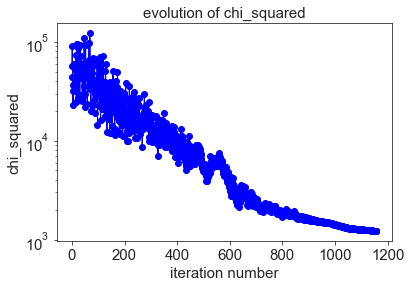

In [8]:
plt.semilogy(chi, marker='o', linewidth=1, color='blue')
plt.xlabel('iteration number', fontsize=15)
plt.ylabel('chi_squared', fontsize=15)
plt.title('evolution of chi_squared', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)